# Analizando la diversion digital

Análisis del desemepeño de los videjuegos vendidos en la plataforma Ice 

## Importacion de librerias

In [1]:
# Carga de librerias
import pandas as pd
import numpy as np
from scipy import stats as st 
import seaborn as sns
from math import factorial
from matplotlib import pyplot as plt

In [2]:
# Carga de los Datasets

games = pd.read_csv('datasets/games.csv')

In [3]:
# Visualizacion de datos

print(games)
games.info()

                                Name Platform  Year_of_Release         Genre  \
0                         Wii Sports      Wii           2006.0        Sports   
1                  Super Mario Bros.      NES           1985.0      Platform   
2                     Mario Kart Wii      Wii           2008.0        Racing   
3                  Wii Sports Resort      Wii           2009.0        Sports   
4           Pokemon Red/Pokemon Blue       GB           1996.0  Role-Playing   
...                              ...      ...              ...           ...   
16710  Samurai Warriors: Sanada Maru      PS3           2016.0        Action   
16711               LMA Manager 2007     X360           2006.0        Sports   
16712        Haitaka no Psychedelica      PSV           2016.0     Adventure   
16713               Spirits & Spells      GBA           2003.0      Platform   
16714            Winning Post 8 2016      PSV           2016.0    Simulation   

       NA_sales  EU_sales  JP_sales  Ot

#### Primer vistazo de los datos en el dataframe

Encontramos datos faltantes o nulos en 6 de las 11 columnas, ademas de mayusculas en el nombre de las columnas, lo cual no sigue las reglas del snake_case, por lo tanto procedemos a nombrar las columnas en minusculas y a analizar los datos faltantes en cada columna para proceder con su procesamiento.

## Procesamiento de los datos

#### Formateo de las columnas en snake_case

In [4]:
# Cambiamos los nombres a minusculas
games.columns = games.columns.str.lower()
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


#### Analisis de datos nulos o faltantes

Se imprimen en pantalla los datos nulos con el fin de encontrarles una explicacion/patron y planear un tratamiento de los mismos

In [5]:
# Imprimimos las filas con valores faltantes en la columna 0 'name' 
print(games[games['name'].isna() == True])

      name platform  year_of_release genre  na_sales  eu_sales  jp_sales  \
659    NaN      GEN           1993.0   NaN      1.78      0.53      0.00   
14244  NaN      GEN           1993.0   NaN      0.00      0.00      0.03   

       other_sales  critic_score user_score rating  
659           0.08           NaN        NaN    NaN  
14244         0.00           NaN        NaN    NaN  


##### Observaciones columna 0 `'name'`
Se aprecia que los valores faltantes de la columna 3 `'genre'` tambien estan en estas dos filas donde les falta el dato del nombre, por lo tanto se procede a eliminar ambas filas pues no se pierden muchos datos, 5 de las 11 filas estan faltantes, por lo que no aportan mucha informacion, incluso tratamos con los faltantes presentes en la columna 3


In [6]:
games = games.dropna(subset=['name']).reset_index(drop=True) 
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16713 entries, 0 to 16712
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16713 non-null  object 
 2   year_of_release  16444 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16713 non-null  float64
 5   eu_sales         16713 non-null  float64
 6   jp_sales         16713 non-null  float64
 7   other_sales      16713 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


##### Observaciones columna 2 `'year_of_release'`
Se aprecia que los valores faltantes de la columna 2 `'year_of_release'` son 269, de los cuales algunos son entregas anuales, mas comunmente los enfocados a deportes, los cuales tienen en su nombre el año posterior al que son lanzados, por lo tanto para no perder más datos, extraeremos el año y lo completaremos en los que sean posibles, en lo que no sean posibles, se eliminaran para no tener valores problema al convertirlos en números enteros.

In [7]:
null_years = games[games['year_of_release'].isna() == True].sort_values(by= 'platform')
#Se extrae los juegos que son de deportes, pues es conocido que son entregas anuales y en el titulo llevan el año, ya sea directo a 4 cifras o en codigo.
null_years_sports = null_years[null_years['genre'] == 'Sports']
null_years_sports_name = null_years_sports['name']
#print(null_years)
print(null_years_sports)

                                         name platform  year_of_release  \
3882                            Fishing Derby     2600              NaN   
8739                                 Home Run     2600              NaN   
15336                            Mario Tennis      3DS              NaN   
10485  Atsumare! Power Pro Kun no DS Koushien       DS              NaN   
15951       PDC World Championship Darts 2008       DS              NaN   
5888                            NBA Live 2003       GC              NaN   
3738                        NBA Street Vol. 2       GC              NaN   
9816                             Street Hoops       GC              NaN   
13791                            NHL Hitz Pro       GC              NaN   
7604                               Famista 64      N64              NaN   
1300                           Triple Play 99       PS              NaN   
183                           Madden NFL 2004      PS2              NaN   
4774                     

In [8]:
#Extraemos los números de los nombres en cada caso diferente
year_number = []
game_name = []
numbers = ''
for name in null_years_sports_name:
    for letter in name:
        if letter.isdigit():
            numbers += letter
    if numbers != "":
        #Para juegos con el año de lanzamiento es del año pasado
        if len(numbers) == 4:
            numbers = float(numbers)
            year_number.append(numbers - 1)
            game_name.append(name)
        #Para juegos con el año comprimido o abreviado 
        elif  len(numbers) == 2:
            numbers = float(numbers)
            if 30 < numbers != 64:
                year_number.append(1899 + numbers)
                game_name.append(name)
            elif 20 > numbers:
                year_number.append(2000 + numbers)
                game_name.append(name)
            elif 20 < numbers != 64 :
                year_number.append(1980 + numbers)
                game_name.append(name)
    numbers = ""

newdict = pd.DataFrame( {
    "name" : game_name,
    "year_of_release" : year_number

})

print(newdict)
#print(year_number)

                                 name  year_of_release
0   PDC World Championship Darts 2008           2007.0
1                       NBA Live 2003           2002.0
2                      Triple Play 99           1998.0
3                     Madden NFL 2004           2003.0
4                    NFL GameDay 2003           2002.0
5              All-Star Baseball 2005           2004.0
6                  MLB SlugFest 20-03           2002.0
7                    FIFA Soccer 2004           2003.0
8                   College Hoops 2K6           2006.0
9      PES 2009: Pro Evolution Soccer           2008.0
10                      Madden NFL 07           2007.0
11          Major League Baseball 2K8           2008.0
12  PDC World Championship Darts 2008           2007.0
13          Major League Baseball 2K6           2006.0
14            Tiger Woods PGA Tour 07           2007.0
15                      Madden NFL 11           2011.0
16                      Madden NFL 06           2006.0
17        

In [9]:
#Eliminamos los duplicados, completamos el dataset, y eliminamos los que no estan completos
newdict.drop_duplicates(inplace=True)
games['year_of_release'] = games['year_of_release'].fillna(
    games['name'].map(newdict.set_index('name')['year_of_release'])
)

games = games.dropna(subset=['year_of_release']).reset_index(drop=True) 
games['year_of_release'] = games['year_of_release'].astype('int')

games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16465 entries, 0 to 16464
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16465 non-null  object 
 1   platform         16465 non-null  object 
 2   year_of_release  16465 non-null  int64  
 3   genre            16465 non-null  object 
 4   na_sales         16465 non-null  float64
 5   eu_sales         16465 non-null  float64
 6   jp_sales         16465 non-null  float64
 7   other_sales      16465 non-null  float64
 8   critic_score     8000 non-null   float64
 9   user_score       9856 non-null   object 
 10  rating           9785 non-null   object 
dtypes: float64(5), int64(1), object(5)
memory usage: 1.4+ MB


####

#### Columna 9 `'user_score'`
Se observa la presencia de valores `'tbd'` que significan 'to be determined', los cuales estorban para realizar calculos matemáticos con los datos, por lo tanto se cambiarán por valores nulos y se convertirá el tipo de dato de la columna a flotante

In [10]:
print(games[games['user_score'] == 'tbd'])
games.loc[games['user_score'] == "tbd",'user_score'] = np.nan

games['user_score'] = games['user_score'].astype('float')*10
games['user_score'].describe()

                                 name platform  year_of_release       genre  \
119                     Zumba Fitness      Wii             2010      Sports   
301    Namco Museum: 50th Anniversary      PS2             2005        Misc   
518                   Zumba Fitness 2      Wii             2011      Sports   
641                      uDraw Studio      Wii             2010        Misc   
711                   Just Dance Kids      Wii             2010        Misc   
...                               ...      ...              ...         ...   
16445                 Planet Monsters      GBA             2001      Action   
16447                Bust-A-Move 3000       GC             2003      Puzzle   
16448                Mega Brain Boost       DS             2008      Puzzle   
16454                        Plushees       DS             2008  Simulation   
16456   Men in Black II: Alien Escape       GC             2003     Shooter   

       na_sales  eu_sales  jp_sales  other_sales  c

count    7476.000000
mean       71.268727
std        14.991124
min         0.000000
25%        64.000000
50%        75.000000
75%        82.000000
max        97.000000
Name: user_score, dtype: float64

#### Columna 10 `'rating'`
Para mejorar la lectura de cada una de las clasificaciones, se extendio el significado de cada una para obtener una mejor informacion con tan solo leerlo.

In [11]:
#Valoramos los valores unicos presentes en la columna rating y ponemos valores mas descriptivos
games['rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

In [12]:
#Algunos raiting no se usan en la actualidad y equivalen de la siguiente manera
def rat_sem(x):
    if x == 'E' or x == 'K-A' or x == 'EC':
        return "Everyone" 
    elif x =='T':
        return "Teens"
    elif x == 'M':
        return "Mature"
    elif x == 'AO':
        return "Adults only"
    elif x == 'E10+':
        return "Everyone 10y+"
    elif x == "RP":
        return "Pending"
    else:
        return "Pending"

In [13]:
#Aplicamos la funcion y creamos otra columna
games['rating_sem'] = games['rating'].apply(rat_sem)
games.sample(10)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,rating_sem
16118,Nitroplus Blasterz: Heroines Infinite Duel,PS3,2015,Fighting,0.00,0.00,0.01,0.00,NaN,NaN,T,Teens
4976,Iron Man 2,PSP,2010,Action,0.18,0.12,0.00,0.07,49.0,NaN,T,Teens
10456,Van Helsing,GBA,2004,Action,0.07,0.03,0.00,0.00,33.0,63.0,T,Teens
1675,Captain Toad: Treasure Tracker,WiiU,2014,Puzzle,0.53,0.38,0.19,0.09,81.0,86.0,E,Everyone
10955,Dark Angel: Vampire Apocalypse,PS2,2001,Role-Playing,0.04,0.03,0.00,0.01,53.0,56.0,T,Teens
11623,Agatha Christie: And Then There Were None,Wii,2008,Adventure,0.06,0.01,0.00,0.01,50.0,62.0,T,Teens
15195,Fallout Trilogy,PC,2004,Role-Playing,0.00,0.02,0.00,0.00,NaN,89.0,M,Mature
8907,Class of Heroes,PSP,2008,Role-Playing,0.06,0.00,0.08,0.01,61.0,71.0,T,Teens
9825,Stolen Song,PS,1998,Adventure,0.00,0.00,0.11,0.01,NaN,NaN,NaN,Pending
15176,Hakuoki: Shinkai - Hana no Shou,PSV,2016,Adventure,0.00,0.00,0.02,0.00,NaN,NaN,NaN,Pending


#### Creacion de columna `'total_sales'`
Para poder analizar el desempeno de ventas de los juegos de manera global, se sumaron todos los ingresos del juego en cada region y se creo la columna total sales.

In [14]:
#Creamos otra columna utilizando la suma de todas las ventas de juegos
games['total_sales'] = games[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum(axis=1)
games.head(10)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,rating_sem,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,80.0,E,Everyone,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,Pending,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,83.0,E,Everyone,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,80.0,E,Everyone,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,Pending,31.38
5,Tetris,GB,1989,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN,Pending,30.26
6,New Super Mario Bros.,DS,2006,Platform,11.28,9.14,6.50,2.88,89.0,85.0,E,Everyone,29.80
7,Wii Play,Wii,2006,Misc,13.96,9.18,2.93,2.84,58.0,66.0,E,Everyone,28.91
8,New Super Mario Bros. Wii,Wii,2009,Platform,14.44,6.94,4.70,2.24,87.0,84.0,E,Everyone,28.32
9,Duck Hunt,NES,1984,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN,Pending,28.31


#### Conclusion del procesamiento de datos
lista de acciones realizadas
* Se cambiaron los nombres de las columnas aplicando el criterio snake_case
* Se completaron los datos faltantes que fueron posibles y se eliminaron los que no fueron necesarios (columna 'year_of_release', 'name' y 'genre')
* Los datos etiquetados como `tbd` fueron cambiados por datos nulos o faltantes, con el fin de cambiar el tipo de dato y evaluarlos matematicamente
* Se creo la columna `rating_sem` el cual nos permite ver de manera mas explicita la clasificacion real de los juegos y no una abreviatura
* La columna `'total_sales'` se creo con el fin de obetner informacion del desempeno global por parte de los juegos, sumando el valor de las cuatro columnas `'x_sales'`

## Análisis de los datos

#### Juegos por año

In [15]:
games_by_year = games.groupby(by='year_of_release').count()['name'].reset_index().rename(columns={'name' : 'number_of_games'})
games_by_year

,year_of_release,number_of_games
0,1980,9
1,1981,46
2,1982,36
3,1983,17
4,1984,14
5,1985,14
6,1986,21
7,1987,16
8,1988,15
9,1989,17


In [16]:
games_by_year['number_of_games'].describe()

count      37.000000
mean      445.000000
std       452.264795
min         9.000000
25%        36.000000
50%       338.000000
75%       764.000000
max      1429.000000
Name: number_of_games, dtype: float64

Encontramos que los años con mayor cantidad de juegos publicados fueron de entre 2005 y 2011, cerca del 50%, posteriormente, regresamos a los valores promedio a los años posteriores.

#### PLataforma por año

In [17]:
#Presencia de dato atipico, 1985 cuando el nintendo DS aparecio en 2004, por lo tanto es imposible, investigando un poco, encontramos que es 2007
games[games['platform'] == 'DS'].sort_values(by= 'year_of_release', ascending=True)


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,rating_sem,total_sales
15723,Strongest Tokyo University Shogi DS,DS,1985,Action,0.00,0.00,0.02,0.00,NaN,NaN,NaN,Pending,0.02
684,WarioWare Touched!,DS,2004,Puzzle,0.51,0.45,1.21,0.13,NaN,NaN,NaN,Pending,2.30
13270,Cocoto Kart Racer,DS,2004,Racing,0.04,0.00,0.00,0.00,NaN,NaN,E,Everyone,0.04
4370,The Urbz: Sims in the City (all regions sales),DS,2004,Simulation,0.40,0.01,0.02,0.00,NaN,NaN,NaN,Pending,0.43
10788,Puyo Pop Fever (JP sales),DS,2004,Puzzle,0.00,0.00,0.09,0.00,NaN,NaN,NaN,Pending,0.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3819,Frozen: Olaf's Quest,DS,2013,Platform,0.21,0.26,0.00,0.04,NaN,NaN,NaN,Pending,0.51
4994,LEGO Marvel Super Heroes,DS,2013,Action,0.22,0.13,0.00,0.03,NaN,48.0,E10+,Everyone 10y+,0.38
14502,LEGO Legends of Chima: Laval's Journey,DS,2013,Adventure,0.00,0.03,0.00,0.00,NaN,NaN,E10+,Everyone 10y+,0.03
14144,Turbo: Super Stunt Squad,DS,2013,Sports,0.00,0.03,0.00,0.00,NaN,NaN,E,Everyone,0.03


In [18]:
#Cambiamos el valor atipico
games.loc[15723, 'year_of_release'] = 2007

In [19]:
table_min_year = pd.pivot_table(games, 'year_of_release', 'platform', aggfunc='min', fill_value=0).rename(columns={'year_of_release':'first_year'})
table_max_year = pd.pivot_table(games, 'year_of_release', 'platform', aggfunc='max', fill_value=0).rename(columns={'year_of_release':'last_year'})
range_table_year = table_min_year.merge(table_max_year, on='platform')
range_table_year['range_years'] = range_table_year['last_year'] - range_table_year['first_year']
range_table_year


,first_year,last_year,range_years
platform,,,
2600,1980,1989,9
3DO,1994,1995,1
3DS,2011,2016,5
DC,1998,2008,10
DS,2004,2013,9
GB,1988,2001,13
GBA,2000,2007,7
GC,2001,2007,6
GEN,1990,1994,4


In [20]:
range_table_year['range_years'].describe()

count    31.000000
mean      7.000000
std       5.899152
min       0.000000
25%       3.000000
50%       6.000000
75%      10.000000
max      31.000000
Name: range_years, dtype: float64

In [21]:
platform_by_year = pd.pivot_table(games, 'name', 'year_of_release', 'platform', aggfunc='count', fill_value=0)
platform_by_year

platform,2600,3DO,3DS,DC,DS,GB,GBA,GC,GEN,GG,...,SAT,SCD,SNES,TG16,WS,Wii,WiiU,X360,XB,XOne
year_of_release,,,,,,,,,,,,,,,,,,,,,
1980,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1981,46,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1982,36,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1983,11,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1984,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1985,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1986,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1987,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1988,2,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


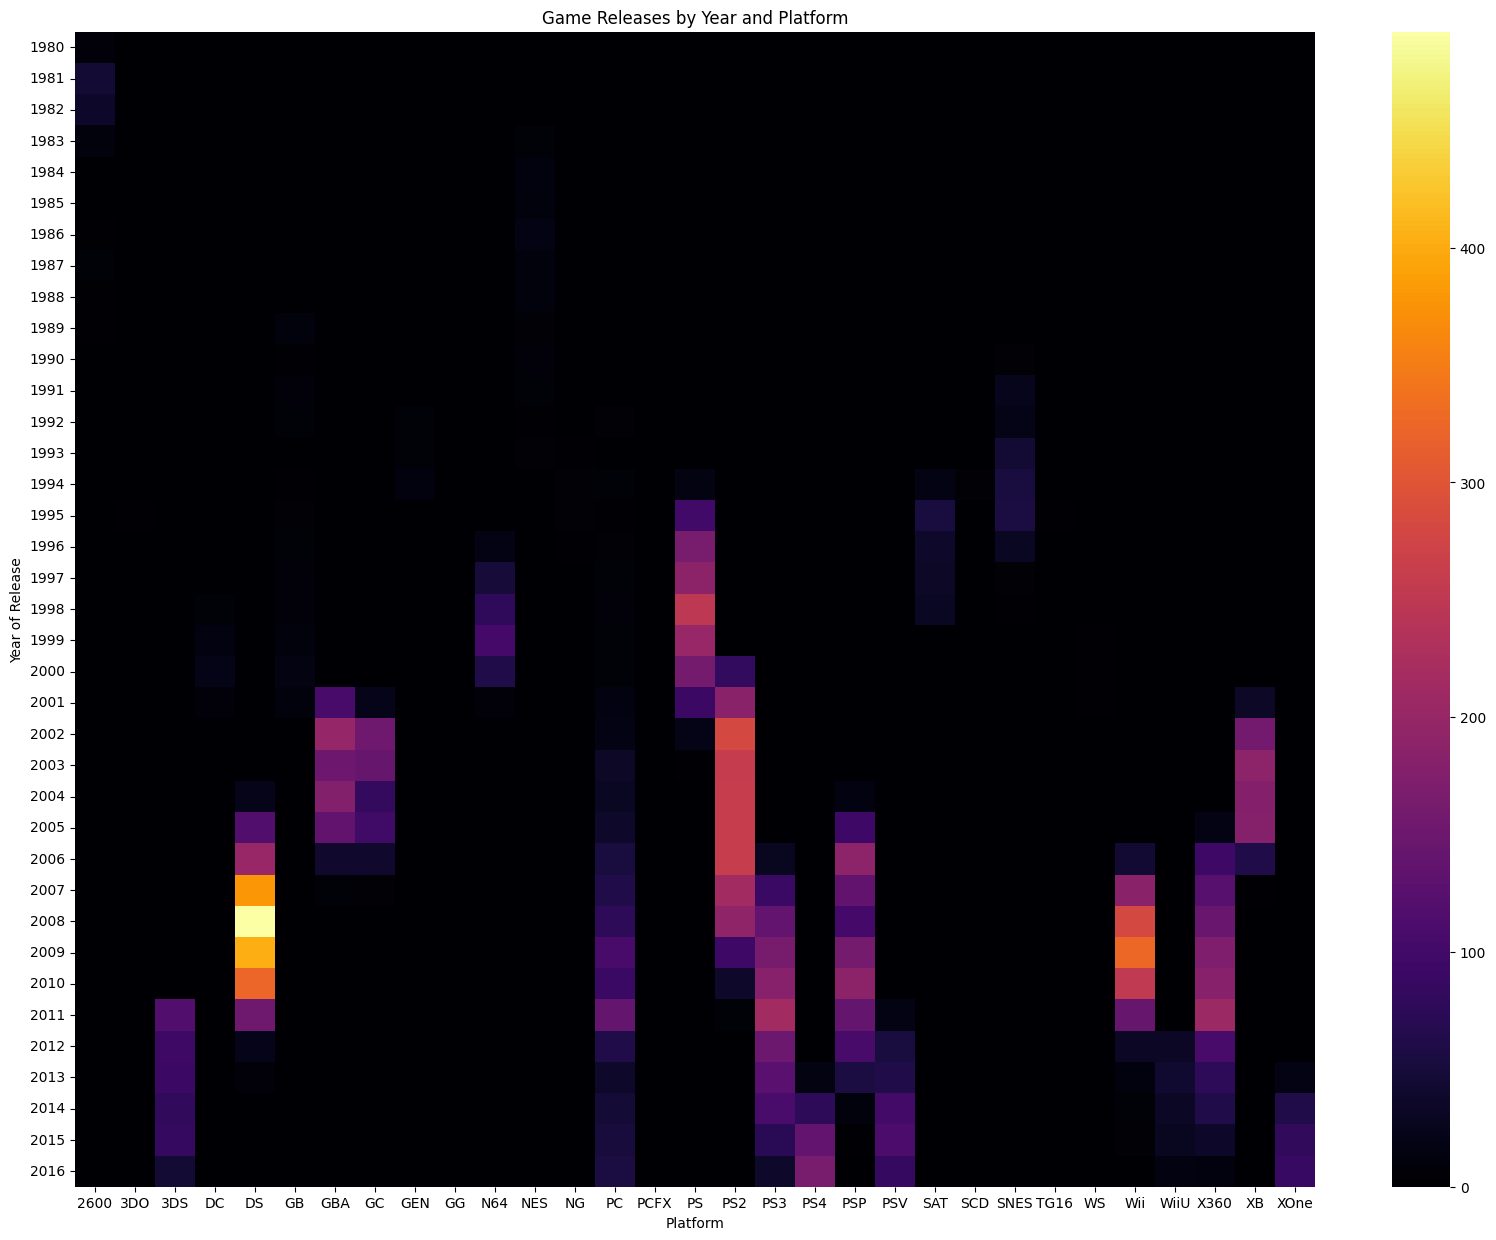

In [22]:

plt.figure(figsize=(20, 15))
sns.heatmap(platform_by_year, cmap="inferno")
plt.title('Game Releases by Year and Platform')
plt.xlabel('Platform')
plt.ylabel('Year of Release')
plt.show()

Tardan entre 6 y 7 años las consolas en desapracer, con respecto en su año de salida, sólo la PC se mantiene constante, con 31 años de duración con respecto a su primer juego publicado hasta la actualidad.

Como se comentó en la sección anterior, aproximadamente el 50% de los juegos fueron publicados entre 2005 y 2011, en donde se concentran las consolas más populares, como la consola de nintendo DS y Wii, además de la presencia del PS2 y PSP por parte de la compañía playstation y la presencia del Xbox360 por parte de Microsoft.

Para la siguiente generación, se tienen las consolas de sobremesa PS4, Xbox One y Wii U; mientras que, las consolas portátiles están en sus años finales o intermedios, pues se nota una ligera disminucción de lanzamientos de juegos en la 3DS y PSV.

Se puede apreciar un arranque lento e incluso un final anticipado por parte de la consola Wii U, pues vemos incluso una disminución de lanzamientos en su consola y considerando que las consolas con mayor volumen de videojuegos son de la compañía Nintendo, dato que contrasta con sus competidores directos, como la Xbox One y PS4, los cuales año con año incrementan la biblioteca de juegos, teniendo una mejor proyección la PS4 de las tres grandes plataformas, el crecimiento de la biblioteca de videjuegos se ve directamente afectado por la aún presencia de lanzamientos en las consolas anteriores.

#### Desempeño por ventas
Se utilizará los datos posteriores al 2005 con el fin de extrapolar el comportamiento de los datos y encontrar un comportamiento del 2017

In [23]:
#Filtramos el dataframe con los datos requeridos (mayores a 2005)
games_2005 = games[games['year_of_release'] >= 2005]
#Se crea la tabla con los datos de ventas globales por plataforma
games_2005['total_sales'].describe()

count    11284.000000
mean         0.483756
std          1.552295
min          0.000000
25%          0.050000
50%          0.140000
75%          0.410000
max         82.540000
Name: total_sales, dtype: float64

In [24]:
games_2005['total_sales'].sum()

np.float64(5458.700000000001)

In [25]:
min_cost_table = pd.pivot_table(games_2005, 'total_sales', 'platform', aggfunc='min').rename(columns={'total_sales':'min_total_sales'})
max_cost_table = pd.pivot_table(games_2005, 'total_sales', 'platform', aggfunc='max').rename(columns={'total_sales':'max_total_sales'})

cost_table = min_cost_table.merge(max_cost_table, on = 'platform')

mean_cost_table = pd.pivot_table(games_2005, 'total_sales', 'platform', aggfunc='mean').rename(columns={'total_sales':'average_total_sales'})


cost_table = cost_table.merge(mean_cost_table, on = 'platform')
cost_table

,min_total_sales,max_total_sales,average_total_sales
platform,,,
3DS,0.01,14.60,0.503535
DC,0.02,0.04,0.030000
DS,0.01,29.80,0.374235
GBA,0.01,2.05,0.236333
GC,0.01,1.68,0.277660
PC,0.01,8.01,0.206384
PS2,0.00,5.95,0.400291
PS3,0.00,21.05,0.713124
PS4,0.01,14.63,0.801378


                                                    name platform  \
0                                             Wii Sports      Wii   
2                                         Mario Kart Wii      Wii   
3                                      Wii Sports Resort      Wii   
7                                               Wii Play      Wii   
8                              New Super Mario Bros. Wii      Wii   
...                                                  ...      ...   
16436  Yattaman Wii: BikkuriDokkiri Machine de Mou Ra...      Wii   
16438                      Outdoors Unleashed: Africa 3D      3DS   
16441                       Dynasty Warriors: Eiketsuden      PS3   
16460                      Samurai Warriors: Sanada Maru      PS3   
16461                                   LMA Manager 2007     X360   

       year_of_release     genre  na_sales  eu_sales  jp_sales  other_sales  \
0                 2006    Sports     41.36     28.96      3.77         8.45   
2            

<Axes: xlabel='platform', ylabel='total_sales'>

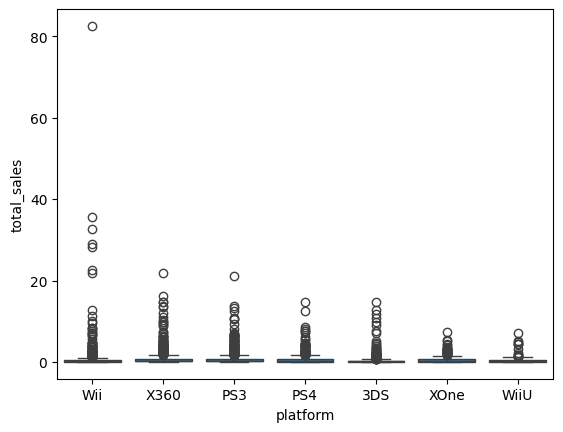

In [26]:
#Nos quedamos con los mas relevantes en fucion en su tiempo y promedio, por lo tanto, nos quedamos con los datos de 3DS, PS3, PS4, Wii, Wii U, X360 y Xone
relevant_platform = ['3DS', 'PS3', 'PS4', 'Wii', 'WiiU', 'X360', 'XOne']
relevant_games_platform = games_2005.query('@relevant_platform in platform')
print(relevant_games_platform)

sns.boxplot(
    data=relevant_games_platform, x='platform', y='total_sales'
    )

Hay muchos datos atípicos, muy por fuera de las medidas de tendencia central de cada juego, incluso no es posible divisar las cajas del diagrama, por lo que hay una gran variabilidad con respecto los juegos con mejor desempeño de ventas, siendo el promedio general 0.48 millones de dólares de ingresos gobales por plataforma, siendo los juegos de las consolas Wii y DS con la mayor cantidad de ingresos máximos.

Con respecto a las consolas de última generación como lo son la Wii, Xbox One y Playstation 4, la que obtiene el mejor desempeño es la PS4, pues en promedio es posible observar una mayor cantidad de ingresos por juegos, teniendo un mayor promedio de los mismos (0.8 M USD), aunado a una cantidad mayor de juegos en su creciente biblioteca, apunta para ser la lider en los próximos años, por otro lado, Xbox one y Wii U tienen una diferencia de 0.14 millones de dólares en promedio, la cantidad de ingresos máximos registrados en juegos palidecen con respecto a PS4, siendo este último el doble con respecto al Wii U y Xbox One.

#### Efecto de críticas y reseñas en las ventas de juegos

C:\Users\Jillean\AppData\Local\Temp\ipykernel_16892\171251819.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xboxone_score_sales['total_sales'] = np.log(xboxone['total_sales'])


,critic_score,user_score,total_sales
critic_score,1.000000,0.472462,0.475427
user_score,0.472462,1.000000,-0.054673
total_sales,0.475427,-0.054673,1.000000


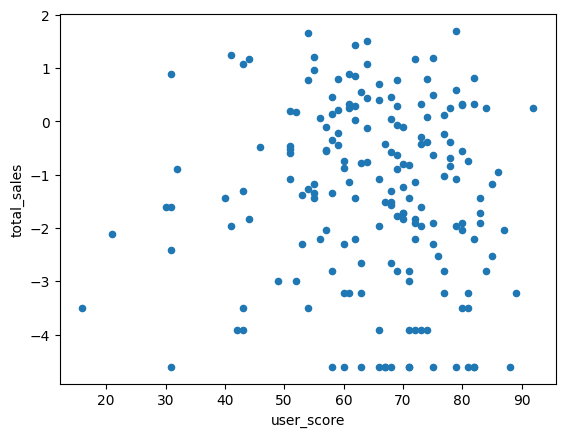

In [27]:
xboxone = games_2005[games_2005['platform'] == 'XOne']
xboxone_score_sales = xboxone[['critic_score', 'user_score', 'total_sales']]
xboxone_score_sales['total_sales'] = np.log(xboxone['total_sales'])
xboxone_score_sales.plot(kind='scatter', x='user_score', y='total_sales')
xboxone_score_sales.corr()


<Axes: xlabel='critic_score', ylabel='total_sales'>

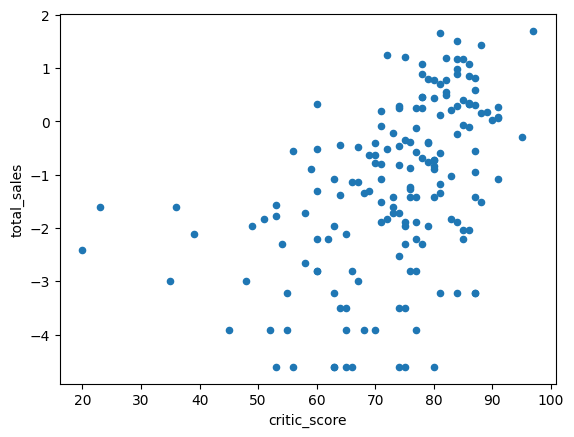

In [28]:
xboxone_score_sales.plot(kind='scatter', x='critic_score', y='total_sales')

C:\Users\Jillean\AppData\Local\Temp\ipykernel_16892\1791909590.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ps4_score_sales['total_sales'] = np.log(ps4_score_sales['total_sales'])


,critic_score,user_score,total_sales
critic_score,1.000000,0.557654,0.479728
user_score,0.557654,1.000000,0.013513
total_sales,0.479728,0.013513,1.000000


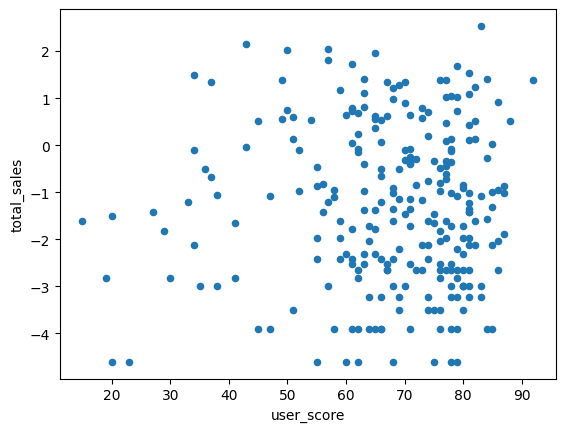

In [29]:
ps4 = games_2005[games_2005['platform'] == 'PS4']
ps4_score_sales = ps4[['critic_score', 'user_score', 'total_sales']]
ps4_score_sales['total_sales'] = np.log(ps4_score_sales['total_sales'])

ps4_score_sales.plot(kind='scatter', x='user_score', y='total_sales')
ps4_score_sales.corr()

<Axes: xlabel='critic_score', ylabel='total_sales'>

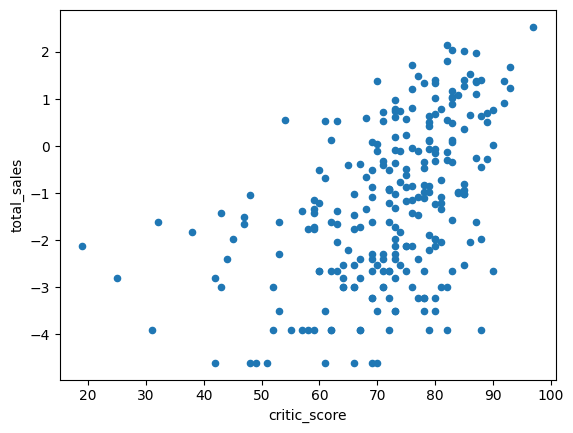

In [30]:
ps4_score_sales.plot(kind='scatter', x='critic_score', y='total_sales')

C:\Users\Jillean\AppData\Local\Temp\ipykernel_16892\2706373869.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wii_u_score_sales['total_sales'] = np.log(wii_u_score_sales['total_sales'])


,critic_score,user_score,total_sales
critic_score,1.000000,0.770080,0.405845
user_score,0.770080,1.000000,0.432733
total_sales,0.405845,0.432733,1.000000


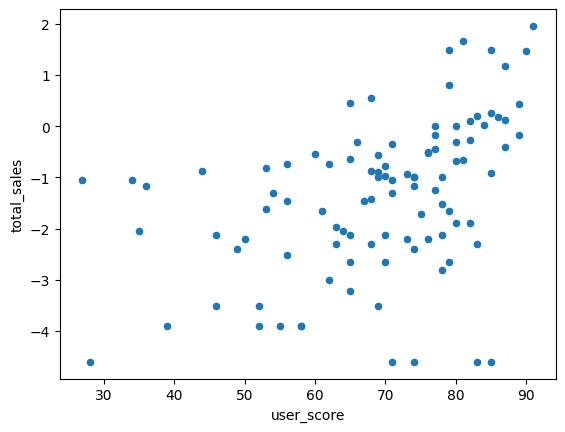

In [31]:
wii_u = games_2005[games_2005['platform'] == 'WiiU']
wii_u_score_sales = wii_u[['critic_score', 'user_score', 'total_sales']]
wii_u_score_sales['total_sales'] = np.log(wii_u_score_sales['total_sales'])
wii_u_score_sales.plot(kind='scatter', x='user_score', y='total_sales')
wii_u_score_sales.corr()

<Axes: xlabel='critic_score', ylabel='total_sales'>

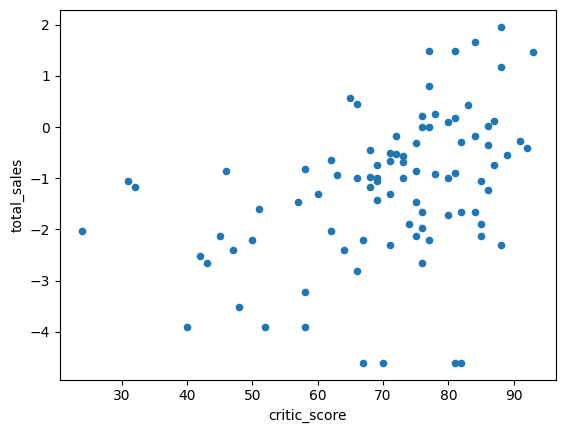

In [32]:
wii_u_score_sales.plot(kind='scatter', x='critic_score', y='total_sales')


Como se observa en los diferentes graficos de dispersión y las diferentes correlaciones, los juegos con mejores puntuaciones dadas porla crítica profesional tienden a tener mayores ingresos, en comparación a las dadas por usuarios, sin embargo, los valores de correlaciones son demasiado bajas, por lo cual no hay una tendencia directa 

#### Efecto de las plataformas en la venta de videjuegos

In [33]:
#Con respecto al las conclusiones previas, manejamos las 3 principales plataformas
important_platform = ['WiiU', 'XOne', 'PS4']
games_diff_platform = games_2005.query('@important_platform in platform')
is_multiplatform = games_diff_platform.groupby('name')['platform'].transform('nunique') > 2
is_multiplatform
multi_platform_games = games_diff_platform[is_multiplatform].copy()
multi_platform_games_table = pd.pivot_table(multi_platform_games, 'total_sales', 'name','platform')
multi_platform_games_table

platform,PS4,WiiU,XOne
name,,,
Adventure Time: Finn & Jake Investigations,0.10,0.05,0.05
Angry Birds Star Wars,0.22,0.10,0.17
Assassin's Creed IV: Black Flag,2.86,0.29,2.24
Call of Duty: Ghosts,3.83,0.35,2.92
Darksiders II,0.23,0.15,0.07
Disney Infinity 2.0: Marvel Super Heroes,0.62,0.65,0.44
Disney Infinity 3.0,0.73,0.46,0.34
Guitar Hero Live,0.86,0.19,0.55
Just Dance 2014,0.42,0.59,0.45


platform,PS4,WiiU,XOne
count,32.000,32.000,32.000
mean,0.910,0.385,0.568
std,1.166,0.270,0.750
min,0.030,0.030,0.010
25%,0.228,0.145,0.155
50%,0.580,0.405,0.340
75%,0.870,0.602,0.530
max,4.320,1.010,2.920


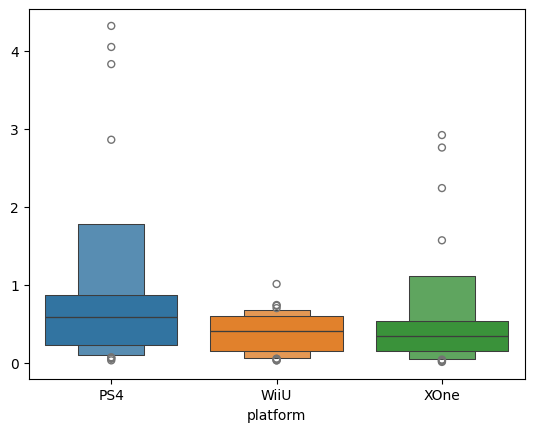

In [34]:
multi_platform_games_graph = sns.boxenplot(multi_platform_games_table)
np.round(multi_platform_games_table.describe(),3)

Como se observa en las medidas de dispersión y tendencia central, con los 32 juegos evaluados, la consola de sony, PlayStation 4, tienen un mejor desempeño en cuanto a las ventas totales,  muy probablemente derivado por la cantidad de unidades vendidas, donde PS4 vendió 40 millones, mientras que xbox one, la plataforma que más se le acerca, no ha podido vender ni la mitad de unidades, mientra que la Wii U, esta teniendo una desacelareción en ventas de consolas, principalmente dado a los rumores de su discontinuación.

#### Géneros de videojuegos de mayor relevancia

In [35]:
relevant_genre_games_mean = games_2005.groupby(by='genre')['total_sales'].mean().sort_values()
relevant_genre_games_mean


genre
Adventure       0.140667
Strategy        0.185829
Puzzle          0.276391
Simulation      0.418665
Misc            0.450168
Fighting        0.456294
Action          0.466819
Role-Playing    0.516195
Racing          0.556473
Sports          0.614907
Platform        0.716454
Shooter         0.910636
Name: total_sales, dtype: float64

<Axes: xlabel='genre'>

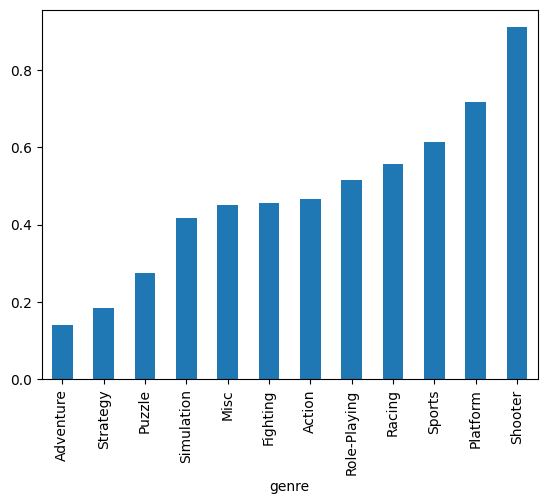

In [36]:
relevant_genre_games_mean.plot.bar()

In [37]:
relevant_genre_games_sum = games_2005.groupby(by='genre')['total_sales'].sum().sort_values()
relevant_genre_games_sum


genre
Strategy          78.42
Puzzle           110.28
Adventure        149.81
Fighting         208.07
Simulation       269.62
Platform         303.06
Racing           355.03
Role-Playing     550.78
Misc             615.83
Shooter          758.56
Sports           857.18
Action          1202.06
Name: total_sales, dtype: float64

<Axes: xlabel='genre'>

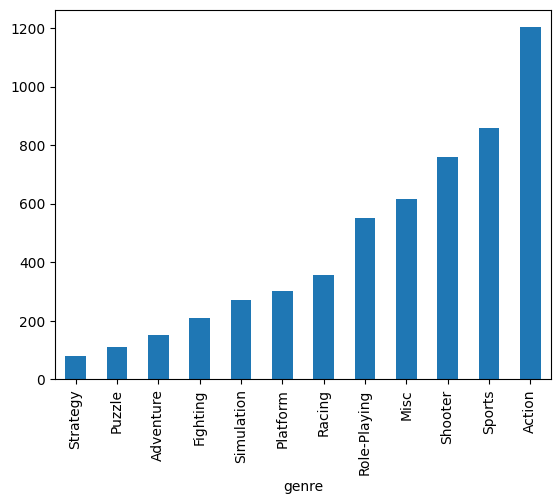

In [38]:
relevant_genre_games_sum.plot.bar()

#### Desempeño por región

In [39]:
#Valor total del mercado por región
games_by_country_genre = games_2005.groupby(by='genre')[['na_sales', 'eu_sales', 'jp_sales']].sum()
games_by_country_genre.sum()

na_sales    2631.56
eu_sales    1617.58
jp_sales     615.87
dtype: float64

In [40]:
#Se obtiene el valor del mercado de las tres regiones registradas por género
games_by_country_genre


,na_sales,eu_sales,jp_sales
genre,,,
Action,580.04,372.58,108.41
Adventure,66.57,39.93,30.27
Fighting,104.63,47.09,31.68
Misc,311.82,167.09,72.49
Platform,149.75,86.93,36.32
Puzzle,49.03,33.81,18.64
Racing,163.58,129.05,17.57
Role-Playing,211.85,115.52,179.60
Shooter,400.96,248.07,20.67


In [41]:
# Se clasifica los valores de las regiones con respecto 
games_by_country_platform = games_2005.groupby(by='platform')[['na_sales', 'eu_sales', 'jp_sales']].sum()
games_by_country_platform

,na_sales,eu_sales,jp_sales
platform,,,
3DS,82.65,61.27,100.62
DC,0.00,0.00,0.06
DS,371.99,184.48,171.37
GBA,26.85,10.19,4.78
GC,27.97,7.47,2.78
PC,45.84,103.01,0.00
PS2,200.61,87.24,50.98
PS3,390.13,327.21,79.41
PS4,108.74,141.09,15.96


In [42]:
games_by_classification = games_2005.groupby(by='rating_sem')[['na_sales', 'eu_sales', 'jp_sales']].sum()
games_by_classification

,na_sales,eu_sales,jp_sales
rating_sem,,,
Adults only,1.26,0.61,0.00
Everyone,877.31,508.95,147.34
Everyone 10y+,343.03,181.92,39.05
Mature,607.34,414.11,46.23
Pending,323.54,253.82,291.93
Teens,479.08,258.17,91.32


El mercado más valioso es el norteamerciano con un valor de alrededor de 2631 millones de dólares en ventas de videojuegos, el cuál tiene una marcada preferencia por los géneros de acción, deportes y disparos, que desde el 2005, las consolas con mayor participación en la compra de titulos en esta zona son la X360, PS3, y el Wii, consolas de la generación anterior y que obtuvieron videojugos de ultima generación en sus catalogos, por su parte, las consolas de nueva generación, la mejor posicionada es la PS4, la cual por sus números, sugieren un crecimiento mayor en los próximos años, mientras que la Xbox one, si bien es la segunda, en terminos de ingresos por juego y cantidad de consolas vendidas, parecen estancarse en este mercado; del Wii U, una consola con rumores de ser descontinuada, es la peor posicionada en esta región. Con respecto al efecto de la clasificacion de los videojuegos, en donde los juegos con clasificaciones más accesibles representan una mayor cantidad de ventas, sin embargo, tanto los dirigidos a publicos mayores de 13 y 17 años igualan los clasificados como todos y todos mayores de 10 años.

El mercado europeo se posiciona como el segundo más importante, con 1600 millones de dólares, en dónde los géneros más populares son los mismos con norteamérica, acción, deportes y disparos; En la misma forma, las consolas con mayor impacto desde el 2005 son PS3, Xbox 360 y Wii, solo difiere la posición de Xbox one con PS3 con respecto a lo mostrado por norteamérica; la diferencia del posicionamiento de consolas de última generación es mucho más marcada, en donde el PS4 es 90 millones de dólares más valiosa con el segundo competidor (Xbox One), mientras que la Wii U sigue siendo bajo (25.13 millones de dolares). Mismo comportamiento por parte de las ventas de norteamérica, si bien tienen mayor cantidad de ventas los clasificados como acceso para todos, pero los dirigidos a publicos mayores se abultan como el segundo rubro en la participación de ventas de videojuegos.

Mientras que el mercado japonés, si bien es el más pequeño de los tres, su valor de 641 millones de dólares no es nada despreciable, sin embargo la forma de consumo por parte del mercado cambia completamente con respecto al norteamericano y europeo, pues los géneros más consumidos son los juegos de Rol, acción, y otros; mientras que las consolas más populares son portables, la Nintendo DS y 3DS, la PS3, dato curioso, la PSP es la cuarta, por lo que el consumo de consolas portátiles es mayor para los usuarios de esta region; mientras que las consolas de nueva generación no estan cerca de ocupar esos espacios, pues PS4 con 15.96 millones de dólares es la más fructuosa,  seguida de la Wii U, mientras que la participación de Xbox One está eclipsada en menos de 1 millón de dólares, por lo que su participación en este mercado no figura en el futuro. En este mercado, se mantienen aquellos que son accesibles a todo el público, y como segundo los dirigidos a los usuarios con edades de 13+, a diferencia de los otros dos mercados, donde los titulos clasificados como 17+ erán los segundos más populares. -->

#### Pruebas estadísticas

##### Hipótesis nula

Las medias de las reseñas de usuarios de las plataformas Xbox One y PC no presentan ninguna diferencia

##### Hipótesis alterna

Las medias de las puntuaciones otorgadas por los usuarios de las plataformas de Xbox One y PC presentan cambios significativos


In [43]:
#Filtramos el dataframe con los datos requeridos
xboxone_critic = games[games['platform'] == 'XOne']['user_score'].dropna()
pc_critic = games[games['platform'] == 'PC']['user_score'].dropna()

alpha = 0.05

levene_platform_critic = st.levene(xboxone_critic, pc_critic)
print(levene_platform_critic.pvalue)

if levene_platform_critic.pvalue < alpha :
   action_vs_sport = st.ttest_ind(xboxone_critic, pc_critic, equal_var = False )
else:
   action_vs_sport = st.ttest_ind(xboxone_critic, pc_critic, equal_var = True )

xbox_vs_pc = st.ttest_ind(xboxone_critic, pc_critic, equal_var = False )
print('El promedio de las críticas de los usuarios de la plataforma Xbox One es', xboxone_critic.mean().round(2), ' con una varianza de ', xboxone_critic.var().round(2))
print('El promedio de las críticas de los usuarios de la plataforma PC es', pc_critic.mean().round(2), ' con una varianza de ', pc_critic.var().round(2))



if (xbox_vs_pc.pvalue < alpha):
    print('Por lo tanto, La hipotesis nula se rechaza')
else:
    print('Se acepta la hipotesis nula')

0.2795532372785057
El promedio de las críticas de los usuarios de la plataforma Xbox One es 65.21  con una varianza de  190.7
El promedio de las críticas de los usuarios de la plataforma PC es 70.66  con una varianza de  234.92
Por lo tanto, La hipotesis nula se rechaza


##### Hipótesis nula

Las calificaciones promedio de los usuarios para los géneros de Acción y Deporte no presentan diferencias significativas

##### Hipótesis alterna

Los géneros de Acción y Deporte tienen calificaciones promedio diferentes.

In [44]:
action_critic = games[games['genre'] == 'Action']['user_score'].dropna()
sport_critic = games[games['genre'] == 'Sports']['user_score'].dropna()

alpha = 0.05

levene_genre_critic = st.levene(action_critic, sport_critic)

if levene_genre_critic.pvalue < alpha :
   action_vs_sport = st.ttest_ind(action_critic, sport_critic, equal_var = False )
else:
   action_vs_sport = st.ttest_ind(action_critic, sport_critic, equal_var = True )


print('El promedio de las críticas de los usuarios del género acción', action_critic.mean().round(2), ' con una varianza de', action_critic.var().round(2))
print('El promedio de las críticas de los usuarios ddel género deportes', sport_critic.mean().round(2), ' con una varianza de', sport_critic.var().round(2))



if (action_vs_sport.pvalue < alpha):
    print('Por lo tanto, La hipotesis nula se rechaza, hay diferencias significativas')
else:
    print('Se acepta la hipotesis nula, al no haber diferencias significativas')

El promedio de las críticas de los usuarios del género acción 70.58  con una varianza de 202.75
El promedio de las críticas de los usuarios ddel género deportes 69.57  con una varianza de 261.34
Se acepta la hipotesis nula, al no haber diferencias significativas


# Conclusiones generales

Con respecto al catalogo de videojuegos, encontró su máximo esplendor en los años 2006 y 2011, en donde rondaban las consolas principales Xbox 360, PS3 y Wii, además de encontrarse las consolas portatiles como Nintendo DS y PSP; en ambos casos la creación de videojuegos se ve altamente incentibada por las ventas de las mismas consolas, además de su longevidad (entre 8 y 10 años), caso contrario con respecto a las consolas retro en donde el promedio se concentraba entre 6 y 7 años.

Para poder inferir el comportamiento de los años posteriores en la venta de videojuegos, es decir 2017, se tomaron en cuenta solo los juegos que fueron publicados despues del 2005, con énfasis en las consolas de última generación (Wii U, PS4 y Xbox One),  dentro de las cuales, es posible observar un comportamiento atípico de algunos videojuegos, mientras que la media se asemaja al 0.5 Millones de dólares, existen videojuegos que presentan una cantidad de ventas superiores a las 10 MDD, como se observa en el diagrama de caja y bigotes.

Con respecto a la relación al puntuación hecha por usuarios y crítica profesional y la cantidad de ventas en MDD, observamos una probre relación, de 0.5 en promedio con respecto a la crítica, mientras que en cuanto a los usuarios es posible observar nula o incluso una correlación negativa, por lo que entre mejor puntuado este el juego a partir de la crítica se traducira en un mejor desempeño, por el contrario, una buena evaluación por parte de los usuarios no garantiza que haya un aumento significativo de ventas.

Como parte de la experiencia de un videojuego, las plataformas en las que se ejecuta suele ser afectar la cantidad de ventas de videojuegos, por lo que se realizó una comparación con titulos que llegaron a las 3 consolas más relevantes en 2016, en donde se vió favorecida la PS4, posteriormente la Xbox One y por último la Wii U, en dónde la PS4 es la más prominente y con mejor pronóstico, mientras que la Wii U hay fuertes rumores de su descontinuación oficial, por lo que muchos desarrolladores de videojuegos no la consideran en las nuevas entregas.

Con respecto a que género de videojuegos son los más rentables,  en promedio, los de disparos, plataforma y deportes fueron los mas beneficiosos, mientras que los que concentran una mayor cantidad de ingresos son los juegos de acción, deportes  y disparos, lo cual es lógico, si observamos que el valor de los mercados norteamericanos y europeos son los más importantes, y los videojuegos más populares en esas regiones corresponden a dichos géneros, siendo la plataforma más popular en los últimos años la PS4, en las tres regiones, la segunda Xbox One en NA y EU, y por último la Wii U que tiene un mejor desempeño en Japón, pero pésimo en todos los demas mercados. Regresando a los géneros, estan ampliamente relacionados los juegos de disparos y acción con clasificaciones tipicamente maduras, por lo que concuerda completamente con lo previamente mencionado, sin embargo, hay una gran presencia de ventas en juegos clasificados como para todos y mayores de 10 años, es decir edades infantiles. 